In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')

In [3]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
bike_rentals.shape

(17379, 17)

In [5]:
bike_rentals.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [6]:
bike_rentals.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

We don't see any missing values.

Our target is `cnt`, which is the total number of bikes people rented in a given hour. Let's look at the distribution of its values.

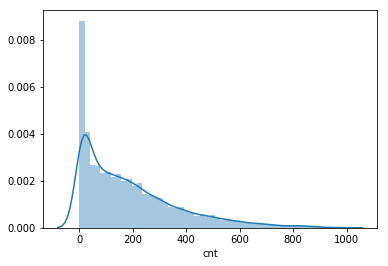

In [7]:
sns.distplot(bike_rentals['cnt'])

To make the `hr` feature more interpretable for the model, we'll split the hours into morning, afternoon, evening, and night.

In [8]:
def assign_label(row):
    if (row['hr'] > 6) & (row['hr'] <= 12):
        return 1
    elif (row['hr'] > 12) & (row['hr'] <= 18):
        return 2
    elif (row['hr'] > 18) & (row['hr'] <= 24):
        return 3
    elif (row['hr'] >= 0) & (row['hr'] <= 6):
        return 4

bike_rentals['time_label'] = bike_rentals.apply(assign_label, axis=1)

Let's look at the correlations each potential features have with our target.

In [9]:
bike_rentals.corr()['cnt'].sort_values()

time_label   -0.494422
hum          -0.322911
weathersit   -0.142426
holiday      -0.030927
weekday       0.026900
workingday    0.030284
windspeed     0.093234
mnth          0.120638
season        0.178056
yr            0.250495
instant       0.278379
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

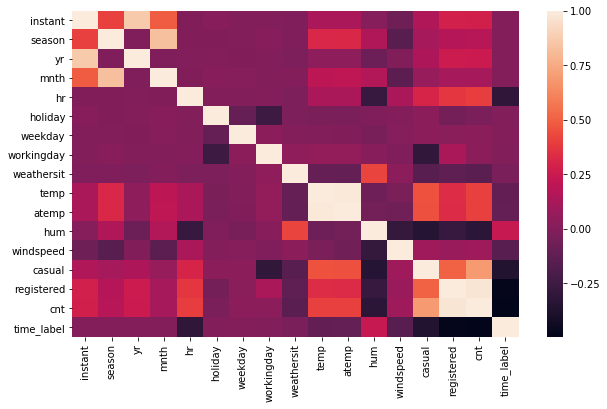

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(bike_rentals.corr())

Which columns to remove from the features list?

`cnt`, `casual`, `dteday`, `registered`, `instant`.

Some columns have high correlations with each other. We'll try to address this down below.

For our error metric, we'll use root mean square error. In the next step, we'll split the data into training and testing datasets.

In [11]:
from sklearn.model_selection import train_test_split
cols = bike_rentals.columns.difference(['cnt', 'casual', 'dteday', 'registered', 'instant'])
train_X, test_X, train_y, test_y = train_test_split(bike_rentals[cols], bike_rentals['cnt'], 
                                                    test_size = 0.3, random_state = 42)

# Linear Regression

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
predictions = lr.fit(train_X, train_y).predict(test_X)
error = np.sqrt(mean_squared_error(test_y, predictions))
print(error)

125.45282495398163


# Decision Tree

In [13]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
predictions = dt.fit(train_X, train_y).predict(test_X)
error = np.sqrt(mean_squared_error(test_y, predictions))
print(error)

61.15222639336496


There's a marked improvement from using a simple linear regression model to a decision tree regressor. Note that data assumptions of linear regression were not considered; RMSE score for linear regression might improve if the assumptions are tests and modified as needed. 

# Random Forests

In [14]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
%timeit predictions = rf.fit(train_X, train_y).predict(test_X)
predictions = rf.fit(train_X, train_y).predict(test_X)
error = np.sqrt(mean_squared_error(test_y, predictions))
print(error)

468 ms ± 7.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
44.730771472535


There's a further reduction in RMSE score. Let's see which features were the most important in this analysis.

# Feature Importance

In [15]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = cols,
                                   columns=['importance']).sort_values('importance',      
                                                                        ascending=False)
feature_importances

,importance
hr,0.385179
time_label,0.227993
temp,0.118931
yr,0.083198
workingday,0.055770
hum,0.026841
season,0.020422
atemp,0.020420
mnth,0.018337
weathersit,0.017876


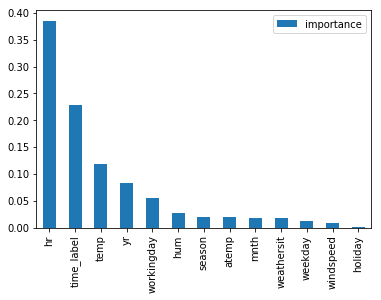

In [16]:
feature_importances.plot.bar()

# Cumulative importance

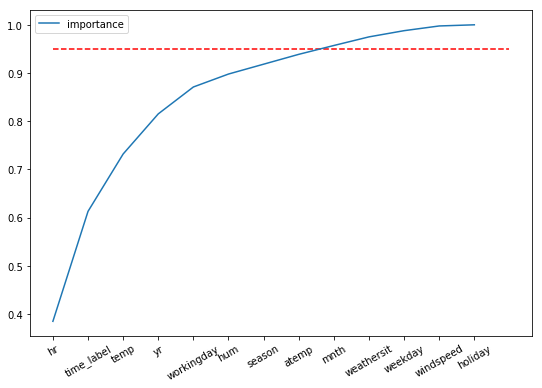

In [17]:
cumulative_importances = np.cumsum(feature_importances)
fig, ax = plt.subplots(figsize=(9,6))
cumulative_importances.plot(ax=ax, rot=30)
ax.set(xticks=range(len(cumulative_importances)),
       xticklabels=cumulative_importances.index)
plt.hlines(y=0.95, xmin=0, xmax=len(cumulative_importances),
           color='r', linestyles='dashed')

In [18]:
cumulative_importances

,importance
hr,0.385179
time_label,0.613172
temp,0.732103
yr,0.815301
workingday,0.871071
hum,0.897912
season,0.918334
atemp,0.938754
mnth,0.957091
weathersit,0.974967


Looks like the first half of features account for more than 90% of feature importance. We'll only keep the first half and re-run Random Forests.

In [19]:
new_cols = cumulative_importances[cumulative_importances['importance']<0.95].index

In [20]:
train_X, test_X, train_y, test_y = train_test_split(bike_rentals[new_cols], bike_rentals['cnt'], 
                                                    test_size = 0.3, random_state = 42)

rf = RandomForestRegressor()
%timeit predictions = rf.fit(train_X, train_y).predict(test_X)
predictions = rf.fit(train_X, train_y).predict(test_X)
error = np.sqrt(mean_squared_error(test_y, predictions))
print(error)

313 ms ± 8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
53.727158779409606


* There was an increase in improvement in speed performance - from 467 ms ± 3.55 ms to 313 ms ± 8.77 ms. 
* RMSE score suffered - from 44.9 to 53.7.

# Randomized search for hyperparameters tuning

We will use `RadomizedSearchCV` to find tune our random forest model.

In [30]:
n_estimators = list(range(200,2001,200))
max_features = ['auto', 'sqrt']
max_depth = list(range(10,111,10))
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

In [32]:
random_grid

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [38]:
train_X, test_X, train_y, test_y = train_test_split(bike_rentals[cols], bike_rentals['cnt'], 
                                                    test_size = 0.3, random_state = 42)

In [39]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=random_grid,
                               n_iter=50,
                               verbose=2,
                               random_state=20,
                               n_jobs=-1)
rf_random.fit(train_X, train_y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 12.8min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=20, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [40]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 40,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [43]:
rf = RandomForestRegressor(bootstrap=True,
                           max_depth=40,
                           max_features='auto',
                           min_samples_leaf=1,
                           min_samples_split=2,
                           n_estimators=1000)
%timeit predictions = rf.fit(train_X, train_y).predict(test_X)
predictions = rf.fit(train_X, train_y).predict(test_X)
error = np.sqrt(mean_squared_error(test_y, predictions))
print(error)

46.6 s ± 641 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
41.692792099149564


* There was a significant decrease in speed performance - from 467 ms ± 3.55 ms to 34.3 seconds ± 857 ms. This is most likely due to increased `n_estimators` hyperparameter.
* RMSE score improved - from 44.9 to 41.7.

# Interpreting random forests

Using `treeinterpreter`, we'll interpret the predictions that our random forests model made with from a couple of data points.

In [44]:
from treeinterpreter import treeinterpreter as ti

In [60]:
%timeit prediction, bias, contributions = ti.predict(rf, bike_rentals[cols].iloc[0:2])
prediction, bias, contributions = ti.predict(rf, bike_rentals[cols].iloc[0:2])

1min 5s ± 1.91 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [61]:
for i, p in enumerate(prediction):
    print('Instance', i)
    print('Bias (trainset mean):', bias[i])
    print('Prediction:', p)
    print('Feature Contributions:')
    for c, feature in sorted(zip(contributions[i],
                                 cols),
                             key=lambda x: -abs(x[0])):
        print(feature, round(c, 2))
    print('-'*20)

Instance 0
Bias (trainset mean): 191.2817912864776
Prediction: 38.924
Feature Contributions:
time_label -82.58
hr -60.08
workingday 35.09
yr -12.62
atemp -12.57
season -11.99
temp -9.08
windspeed 3.2
mnth -2.61
weekday -1.33
hum 0.96
holiday 0.73
weathersit 0.52
--------------------
Instance 1
Bias (trainset mean): 191.2817912864776
Prediction: 35.066
Feature Contributions:
time_label -82.58
hr -63.31
workingday 27.93
atemp -18.89
yr -9.18
season -8.37
temp -7.25
hum 3.68
windspeed 2.14
mnth -1.19
weathersit 0.83
weekday -0.67
holiday 0.64
--------------------


As we can see, contributions from each features are weighted differently for the two data points. This gives a good idea on which features and the degree of their contribution to the prediction of each data point. We should note that the runtime for this model is extremely long. For real life application, we may have to decrease `n_estimators` to ensure that our model isn't too slow.